In [33]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from tqdm import tqdm
import imageio
import os
from scipy import stats

import requests
import warnings
warnings.filterwarnings("ignore")

In [34]:
snap_df = pd.read_csv("../data/SNAP_data_raw.csv")

snap_df["Average Monthly SNAP Benefits per Participant"] = (
    snap_df["Average Monthly SNAP Benefits per Participant"]
    .str.removeprefix("$")
    .replace("N/A", np.nan)
    .astype("float32")
)

snap_df["Average Monthly SNAP Participants"] = (
    snap_df["Average Monthly SNAP Participants"]
    .str.removesuffix(" 1")
    .str.replace(",", "")
    .replace("N/A", np.nan)
    .astype("float32")
)

snap_df["Total Benefits"] = (
    snap_df["Total Benefits"]
    .str.removeprefix("$")
    .str.replace(",", "")
    .str.removesuffix(" 1")
    .replace("N/A", np.nan)
    .astype("int64")
)

snap_df["year"] = snap_df["year"].astype("int16")

snap_df.drop("Unnamed: 0", axis=1, inplace=True)

# geometry shape file - state level
sgdf = gpd.read_file("../data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)

## Walkability data

Rationale: [Obesity noodle map](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/296290/obesity-map-full-hi-res.pdf)


In [35]:
df_walk = pd.read_csv("../data/walkability.csv")

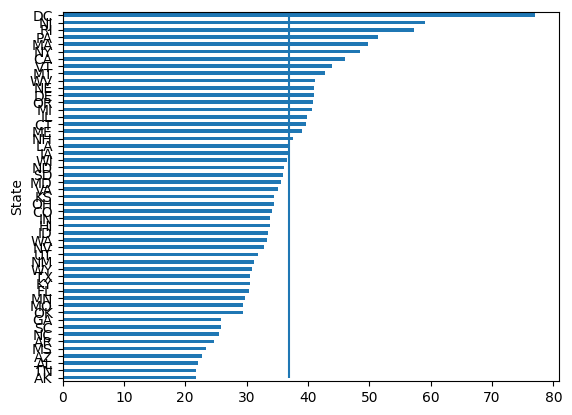

In [36]:
ax = (
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=True)
    .plot.barh()
)

ax.vlines(df_walk["Walk Score"].mean(), 0, 1000)

## Activity (CDC) data


In [37]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")

# YearStart and YearEnd contain the same data
assert (df_nutri["YearEnd"] != df_nutri["YearStart"]).sum() == 0

# We give the columns dropped and reasons for dropping
# 1. Data_Value_Unit: Contains all null data
# 2. Total
# 3. Data_Value_Type
# 4. Geolocation: Shape file will be merged externally for choropleth mapping
# 5. YearEnd: Contains the same data as "YearStart"
# 6. Datasource: Contains the same vale: "Youth Risk Behavior Surveillance System"
df_nutri.drop(
    [
        "Data_Value_Unit",
        "Total",
        "Data_Value_Type",
        "GeoLocation",
        "YearEnd",
        "Datasource",
    ],
    axis=1,
    inplace=True,
)
df_nutri = df_nutri.query("LocationDesc != 'Guam'")

In [38]:
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39760 entries, 0 to 40095
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   39760 non-null  int64  
 1   LocationAbbr                39760 non-null  object 
 2   LocationDesc                39760 non-null  object 
 3   Class                       39760 non-null  object 
 4   Topic                       39760 non-null  object 
 5   Question                    39760 non-null  object 
 6   Data_Value                  29212 non-null  float64
 7   Data_Value_Alt              29212 non-null  float64
 8   Data_Value_Footnote_Symbol  10548 non-null  object 
 9   Data_Value_Footnote         10548 non-null  object 
 10  Low_Confidence_Limit        29212 non-null  float64
 11  High_Confidence_Limit       29212 non-null  float64
 12  Sample_Size                 29212 non-null  float64
 13  Gender                      5680 non

In [39]:
df_nutri.StratificationCategory1.unique()

array(['Race/Ethnicity', 'Total', 'Grade', 'Gender'], dtype=object)

In [40]:
df_nutri.apply(lambda x: x.nunique())

YearStart                       10
LocationAbbr                    51
LocationDesc                    51
Class                            5
Topic                            5
Question                         8
Data_Value                     677
Data_Value_Alt                 677
Data_Value_Footnote_Symbol       1
Data_Value_Footnote              1
Low_Confidence_Limit           623
High_Confidence_Limit          760
Sample_Size                   4415
Gender                           2
Grade                            4
Race/Ethnicity                   9
ClassID                          5
TopicID                          5
QuestionID                       8
DataValueTypeID                  1
LocationID                      51
StratificationCategory1          4
Stratification1                 14
StratificationCategoryId1        4
StratificationID1               14
dtype: int64

Unique question in the dataset:

|     | ClassID | QuestionID | Question                                                                                                                    |
| --: | :------ | :--------- | :-------------------------------------------------------------------------------------------------------------------------- |
|   0 | FV      | Q020       | Percent of students in grades 9-12 who consume fruit less than 1 time daily                                                 |
|   1 | FV      | Q021       | Percent of students in grades 9-12 who consume vegetables less than 1 time daily                                            |
|   2 | OWS     | Q038       | Percent of students in grades 9-12 who have obesity                                                                         |
|   3 | OWS     | Q039       | Percent of students in grades 9-12 who have an overweight classification                                                    |
|   4 | PA      | Q048       | Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily |
|   5 | PA      | Q049       | Percent of students in grades 9-12 who participate in daily physical education                                              |
|   6 | SD      | Q058       | Percent of students in grades 9-12 who drank regular soda/pop at least one time per day                                     |
|   7 | TV      | Q059       | Percent of students in grades 9-12 watching 3 or more hours of television each school day                                   |

(table generated with code:

```python
print(df_nutri.groupby(["ClassID", "QuestionID"])["Question"]
      .unique()
      .reset_index()
      .explode("Question")
      .to_markdown())
```

)

ClassID:

- FV: Fruit and vegetables
- OWS: Obesity and Weight Status
- PA: Physical activity
- SD: Soda drink consumption
- TV: TV watching behavior


In [41]:
gend_obesity = df_nutri[
    [
        "YearStart",
        "LocationAbbr",
        "LocationDesc",
        "Data_Value",
        "QuestionID",
        "StratificationCategory1",
        "Stratification1",
    ]
].query(
    "StratificationCategory1 == 'Gender' & QuestionID == 'Q038' & YearStart == 2019"
)
gend_obesity

,YearStart,LocationAbbr,LocationDesc,Data_Value,QuestionID,StratificationCategory1,Stratification1
7,2019,NE,Nebraska,10.3,Q038,Gender,Female
335,2019,RI,Rhode Island,10.5,Q038,Gender,Female
554,2019,AL,Alabama,15.3,Q038,Gender,Female
886,2019,MI,Michigan,16.7,Q038,Gender,Male
967,2019,NJ,New Jersey,13.9,Q038,Gender,Male
...,...,...,...,...,...,...,...
13070,2019,PR,Puerto Rico,11.8,Q038,Gender,Female
13096,2019,IA,Iowa,19.2,Q038,Gender,Male
13114,2019,MO,Missouri,22.7,Q038,Gender,Male
13159,2019,ND,North Dakota,11.5,Q038,Gender,Female


In [42]:
snap_gend_ovw = gend_obesity.merge(
    snap_df[
        ["Location", "Average Monthly SNAP Benefits per Participant", "year"]
    ].query("year == 2019"),
    left_on="LocationDesc",
    right_on="Location",
    how="inner",
)

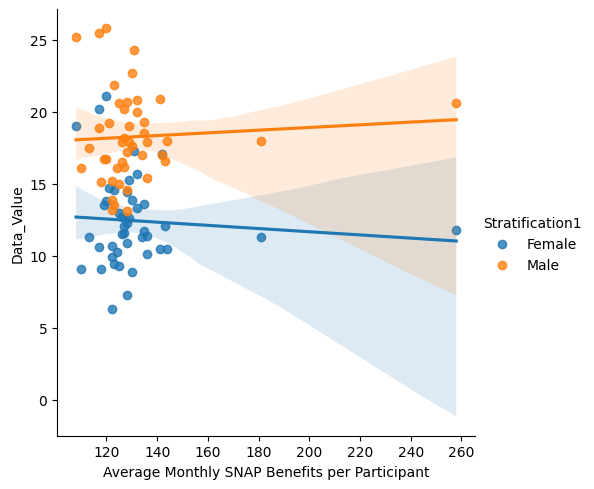

In [43]:
sns.lmplot(data = snap_gend_ovw, x = "Average Monthly SNAP Benefits per Participant", y = "Data_Value", hue = "Stratification1")

In [44]:
g1 = snap_gend_ovw[snap_gend_ovw['Stratification1'] == 'Female']["Data_Value"]
g2 = snap_gend_ovw[snap_gend_ovw['Stratification1'] == 'Male']["Data_Value"]

# # First, test for the data's normality and homoscedasticity and see if it
# # is suitable for doing an ANOVA
pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(snap_gend_ovw["Data_Value"]),
        "Shapiro-Wilk's test of normality (Female)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Male)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=["Test Statistics", "p-value"],
).T  # transpose dataframe for better readability

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.982351,0.261995
Shapiro-Wilk's test of normality (Female),0.946188,0.036492
Shapiro-Wilk's test of normality (Male),0.953032,0.066210
Levene's test of homoscedasticity,0.091270,0.763281


In [45]:
sm.stats.anova_oneway(data = snap_gend_ovw['Data_Value'], groups=snap_gend_ovw['Stratification1'], use_var='unequal')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 77.84159865897968
pvalue = 9.54783297313472e-14
df = (1.0, 87.95190650884088)
df_num = 1.0
df_denom = 87.95190650884088
nobs_t = 90.0
n_groups = 2
means = array([12.44      , 18.27111111])
nobs = array([45., 45.])
vars_ = array([ 9.59836364, 10.0580101 ])
use_var = 'unequal'
welch_correction = True
tuple = (77.84159865897968, 9.54783297313472e-14)

In [46]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

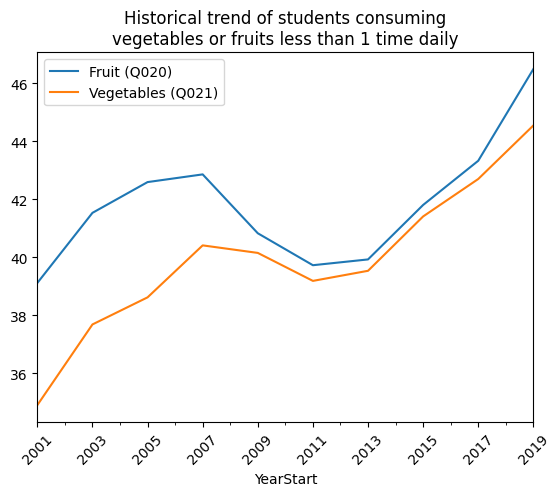

In [47]:
register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x="YearStart")
ax.set_title(
    "Historical trend of students consuming\nvegetables or fruits less than 1 time daily"
)
xticks = pd.date_range(
    start=vegetable_trend["YearStart"].min(), end="2020-01-01", freq="2Y"
)
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text("Fruit (Q020)")
L.get_texts()[1].set_text("Vegetables (Q021)")

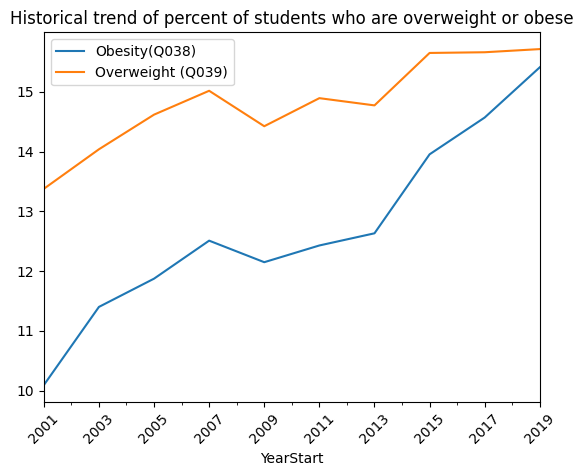

In [48]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = obesity_trend.plot.line(x="YearStart")
ax.set_title("Historical trend of percent of students who are overweight or obese")
xticks = pd.date_range(
    start=obesity_trend["YearStart"].min(), end="2020-01-01", freq="2Y"
)
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text("Obesity(Q038)")
L.get_texts()[1].set_text("Overweight (Q039)")

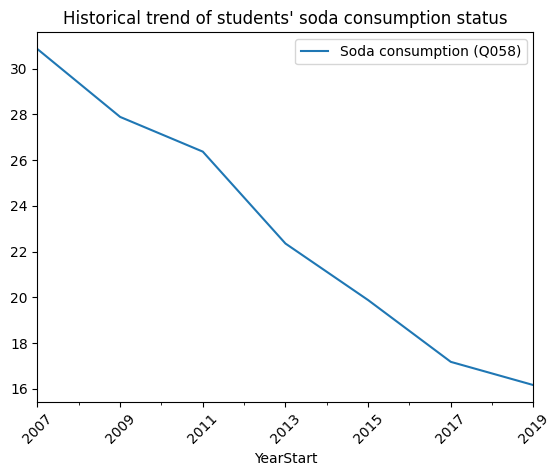

In [49]:
soda_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'SD'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = soda_trend.plot.line(x="YearStart")
ax.set_title("Historical trend of students' soda consumption status")
xticks = pd.date_range(start=soda_trend["YearStart"].min(), end="2020-01-01", freq="2Y")
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text("Soda consumption (Q058)")

In [56]:
walk_physical = df_nutri.query(
    "YearStart == 2019 & QuestionID == 'Q048' & Stratification1 == 'Total'"
).merge(
    (
        df_walk[["State", "Walk Score", "Bike Score"]]
        .groupby("State")[["Walk Score", "Bike Score"]]
        .mean()
    ),
    how="inner",
    left_on="LocationAbbr",
    right_on="State",
)

walk_physical.head(3)

,YearStart,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,...,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1,Walk Score,Bike Score
0,2019,TX,Texas,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,22.9,22.9,NaN,NaN,...,PA1,Q048,VALUE,48,Total,Total,OVR,OVERALL,30.575949,38.031646
1,2019,RI,Rhode Island,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,21.1,21.1,NaN,NaN,...,PA1,Q048,VALUE,44,Total,Total,OVR,OVERALL,57.333333,45.222222
2,2019,MS,Mississippi,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,23.4,23.4,NaN,NaN,...,PA1,Q048,VALUE,28,Total,Total,OVR,OVERALL,23.375000,33.583333


In [57]:
# sample size * data value = % of people who ___question condition___
calc_people = lambda x, y: x * y
# todo: availability of parks?
smf.ols(
    "calc_people(Q('Sample_Size'), Q('Data_Value')) ~ Q('Walk Score') + Q('Bike Score')",
    data=walk_physical,
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     calc_people(Q('Sample_Size'), Q('Data_Value'))   R-squared:                       0.044
Model:                                                        OLS   Adj. R-squared:                 -0.001
Method:                                             Least Squares   F-statistic:                    0.9725
Date:                                            Wed, 06 Dec 2023   Prob (F-statistic):              0.386
Time:                                                    13:52:30   Log-Likelihood:                -541.44
No. Observations:                                              45   AIC:                             1089.
Df Residuals:                                                  42   BIC:                             1094.
Df Model:                                                       2                                         
Covariance Type:                                        nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.727e+04   3.19e+04      0.856      0.397    -3.7e+04    9.16e+04
Q('Walk Score')   746.9438    765.640      0.976      0.335    -798.180    2292.068
Q('Bike Score')   126.7721    987.604      0.128      0.898   -1866.293    2119.837
==============================================================================
Omnibus:                       22.252   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.083
Skew:                           1.657   Prob(JB):                     1.78e-07
Kurtosis:                       5.366   Cond. No.                         287.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Walk Score', ylabel='Data_Value'>

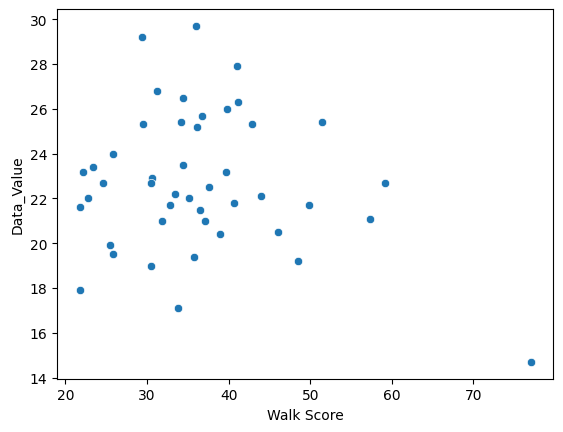

In [58]:
sns.scatterplot(
    data=walk_physical,
    x="Walk Score",
    y="Data_Value",
)

In [59]:
obs_snap_reg = (
    df_nutri.query(
        "YearStart == 2019 & Stratification1 == 'Total' & (QuestionID == 'Q038' | QuestionID == 'Q039')"
    )
    .groupby("LocationDesc")["Data_Value"]
    .sum()
    .reset_index()
    .merge(
        snap_df.query(
            "year == 2019 & Location != 'United States' & Location != 'Guam'"
        ),
        how="inner",
        left_on="LocationDesc",
        right_on="Location",
    )
)[
    [
        "LocationDesc",
        "Data_Value",
        "Average Monthly SNAP Benefits per Participant",
        "Average Monthly SNAP Participants",
        "Total Benefits",
        "year",
    ]
]

<Axes: xlabel='Data_Value', ylabel='Total Benefits'>

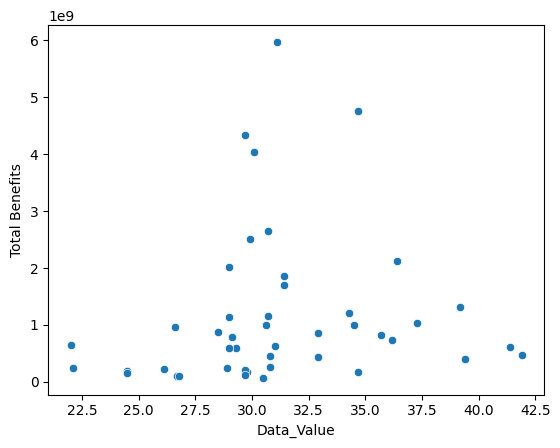

In [60]:
sns.scatterplot(data=obs_snap_reg, x="Data_Value", y="Total Benefits")

In [61]:
smf.ols("Q('Data_Value') ~ Q('Total Benefits')", data=obs_snap_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5763
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.452
Time:                        13:52:30   Log-Likelihood:                -131.02
No. Observations:                  45   AIC:                             266.0
Df Residuals:                      43   BIC:                             269.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              30.6942      0.901     34.063      0.000      28.877      32.511
Q('Total Benefits')  3.907e-10   5.15e-10      0.759      0.452   -6.47e-10    1.43e-09
==============================================================================
Omnibus:                        3.017   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.176
Skew:                           0.527   Prob(JB):                        0.337
Kurtosis:                       3.224   Cond. No.                     2.33e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
snap_df.year.min(), snap_df.year.max(), df_nutri.YearStart.max(), df_nutri.YearStart.min()

(2002, 2022, 2019, 2001)

In [63]:
hist_soda_snap = pd.DataFrame({"Year": [], "R-Squared": [], "p-value": []})

for i in range(2002, 2020):
    try:
        soda_snap_reg = (
            df_nutri.query(
                f"YearStart == {i} & Stratification1 == 'Total' & (QuestionID == 'Q058')"
            )
            .groupby("LocationDesc")["Data_Value"]
            .sum()
            .reset_index()
            .merge(
                snap_df.query(
                    f"year == {i} & Location != 'United States' & Location != 'Guam'"
                ),
                how="inner",
                left_on="LocationDesc",
                right_on="Location",
            )
        )[
            [
                "LocationDesc",
                "Data_Value",
                "Average Monthly SNAP Benefits per Participant",
                "Average Monthly SNAP Participants",
                "Total Benefits",
                "year",
            ]
        ]

        reg = smf.ols(
            "Q('Data_Value') ~ Q('Average Monthly SNAP Benefits per Participant')",
            data=soda_snap_reg,
        ).fit()
        t = pd.DataFrame(
            {"Year": [i], "R-Squared": [reg.rsquared], "p-value": [reg.f_pvalue]}
        )
        hist_soda_snap = pd.concat([hist_soda_snap, t])
    except:
        pass
hist_soda_snap

,Year,R-Squared,p-value
0,2007.0,0.049674,0.172629
0,2009.0,0.092300,0.056669
0,2011.0,0.092225,0.053574
0,2013.0,0.010232,0.523865
0,2015.0,0.080865,0.088048
0,2017.0,0.064484,0.129365
0,2019.0,0.080194,0.080653


In [64]:
soda_snap_reg = (
    df_nutri.query(f"Stratification1 == 'Total' & (QuestionID == 'Q058')")
    .groupby(["LocationDesc", "YearStart"])["Data_Value"]
    .sum()
    .reset_index()
    .merge(
        snap_df.query(f"Location != 'United States' & Location != 'Guam'"),
        how="inner",
        left_on=["LocationDesc", "YearStart"],
        right_on=["Location", "year"],
    )
)[
    [
        "LocationDesc",
        "Data_Value",
        "Average Monthly SNAP Benefits per Participant",
        "Average Monthly SNAP Participants",
        "Total Benefits",
        "year",
    ]
]

In [65]:
results = smf.ols(
    "Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Benefits per Participant')",
    data=soda_snap_reg,
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     25.82
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           7.30e-27
Time:                        13:52:30   Log-Likelihood:                -906.12
No. Observations:                 275   AIC:                             1828.
Df Residuals:                     267   BIC:                             1857.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             38.8344      2.372     16.373      0.000      34.164      43.504
C(year)[T.2009]                                       -0.3544      1.627     -0.218      0.828      -3.557       2.848
C(year)[T.2011]                                       -0.9139      1.706     -0.536      0.593      -4.272       2.444
C(year)[T.2013]                                       -7.3406      1.678     -4.376      0.000     -10.644      -4.038
C(year)[T.2015]                                       -7.9802      1.684     -4.739      0.000     -11.296      -4.665
C(year)[T.2017]                                      -10.7311      1.670     -6.426      0.000     -14.019      -7.443
C(year)[T.2019]                                      -11.3114      1.702     -6.646      0.000     -14.662      -7.961
Q('Average Monthly SNAP Benefits per Participant')    -0.0833      0.022     -3.751      0.000      -0.127      -0.040
==============================================================================
Omnibus:                        5.359   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                7.602
Skew:                          -0.030   Prob(JB):                       0.0224
Kurtosis:                       3.812   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
results.f_pvalue

7.295387496084583e-27

In [67]:
# do an ANOVA for walkability score and % of teenagers with obesity status
from scipy import stats

obesity_df = (
    df_nutri.query(
        "YearStart == 2019 & Stratification1 == 'Total' & (QuestionID == 'Q038' | QuestionID == 'Q039')"
    )
    .groupby(["LocationAbbr", "LocationDesc"])["Data_Value"]
    .sum()
    .reset_index()
    
)

walkability_t10_obesity = (
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(10)
    .merge(obesity_df[['LocationAbbr', 'Data_Value']], 
           how = "inner",
           left_on = "State",
           right_on = "LocationAbbr")
    .assign(grouping = "top10")
)

walkability_b10_obesity = (
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .tail(10)
    .merge(obesity_df[['LocationAbbr', 'Data_Value']], 
           how = "inner",
           left_on = "State",
           right_on = "LocationAbbr")
    .assign(grouping = "bottom10")
)

overall = pd.concat([walkability_b10_obesity, walkability_t10_obesity])
# Use ANOVA to find if there is significant difference between rural and urban counties
# overdose death count
g1 = overall[overall['grouping'] == 'top10']["Walk Score"]
g2 = overall[overall['grouping'] == 'bottom10']["Walk Score"]

# # First, test for the data's normality and homoscedasticity and see if it
# # is suitable for doing an ANOVA
pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(overall["Walk Score"]),
        "Shapiro-Wilk's test of normality (Top 10)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Bottom 10)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=["Test Statistics", "p-value"],
).T  # transpose dataframe for better readability

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.875347,0.014607
Shapiro-Wilk's test of normality (Top 10),0.851825,0.061064
Shapiro-Wilk's test of normality (Bottom 10),0.899474,0.216198
Levene's test of homoscedasticity,4.279389,0.053252


In [68]:
sm.stats.anova_oneway(data = overall['Data_Value'], groups=overall['grouping'], use_var='unequal')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 8.371599994088893
pvalue = 0.009685506838603714
df = (1.0, 17.99360807655516)
df_num = 1.0
df_denom = 17.99360807655516
nobs_t = 20.0
n_groups = 2
means = array([35.67, 30.06])
nobs = array([10., 10.])
vars_ = array([19.15122222, 18.44266667])
use_var = 'unequal'
welch_correction = True
tuple = (8.371599994088893, 0.009685506838603714)

In [69]:
walkability_t10_obesity

,State,Walk Score,LocationAbbr,Data_Value,grouping
0,DC,77.000000,DC,34.7,top10
1,NJ,59.147541,NJ,26.6,top10
2,RI,57.333333,RI,28.9,top10
3,PA,51.378378,PA,29.9,top10
4,MA,49.819444,MA,29.0,top10
5,NY,48.450450,NY,29.7,top10
6,CA,46.072581,CA,31.1,top10
7,VT,44.000000,VT,26.8,top10
8,MT,42.857143,MT,24.5,top10
9,WV,41.100000,WV,39.4,top10


In [70]:
(
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(10)
)

,State,Walk Score
0,DC,77.000000
1,NJ,59.147541
2,RI,57.333333
3,PA,51.378378
4,MA,49.819444
5,NY,48.450450
6,CA,46.072581
7,VT,44.000000
8,MT,42.857143
9,WV,41.100000


## Choropleth mapping

  0%|          | 0/10 [00:00<?, ?it/s]

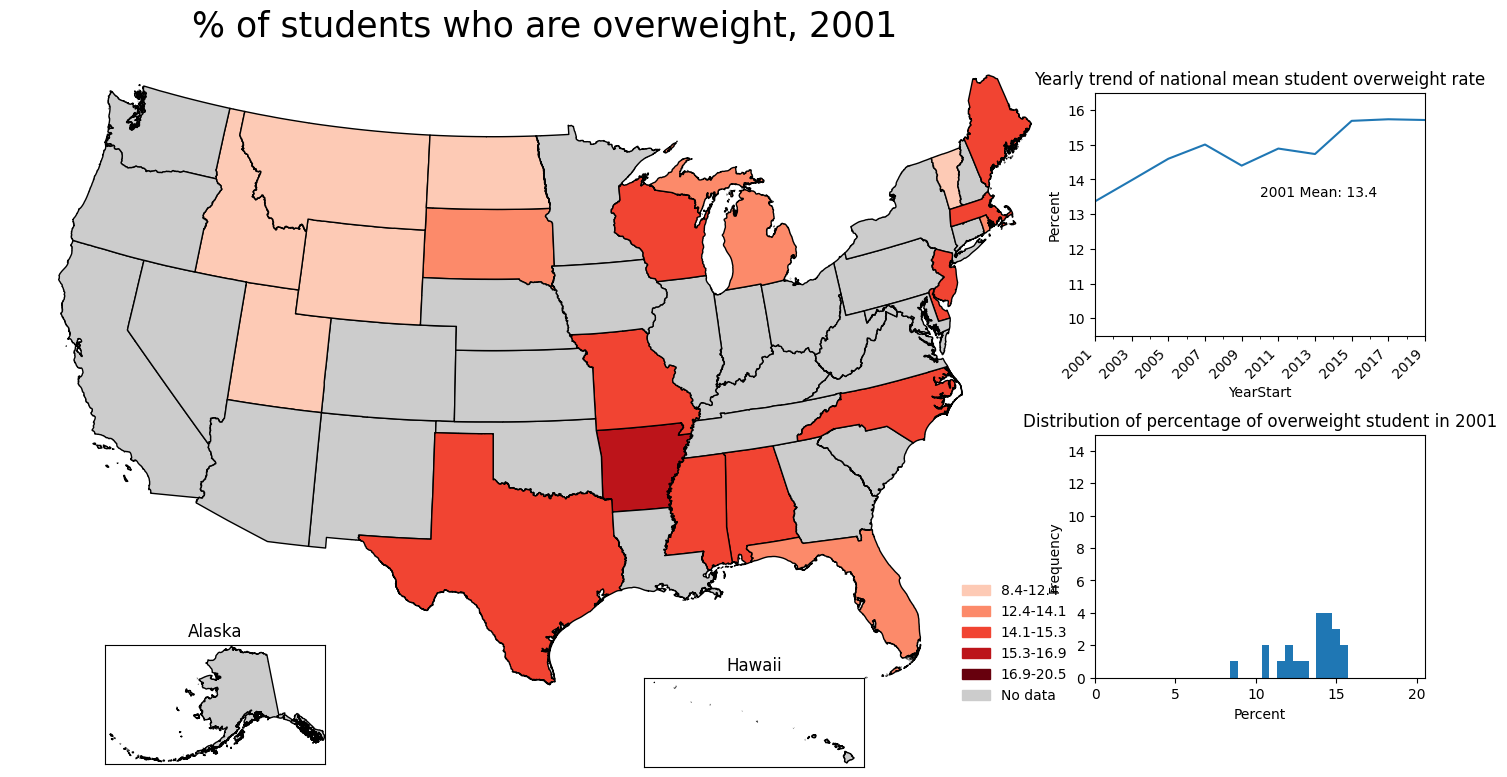

 10%|█         | 1/10 [00:00<00:05,  1.53it/s]

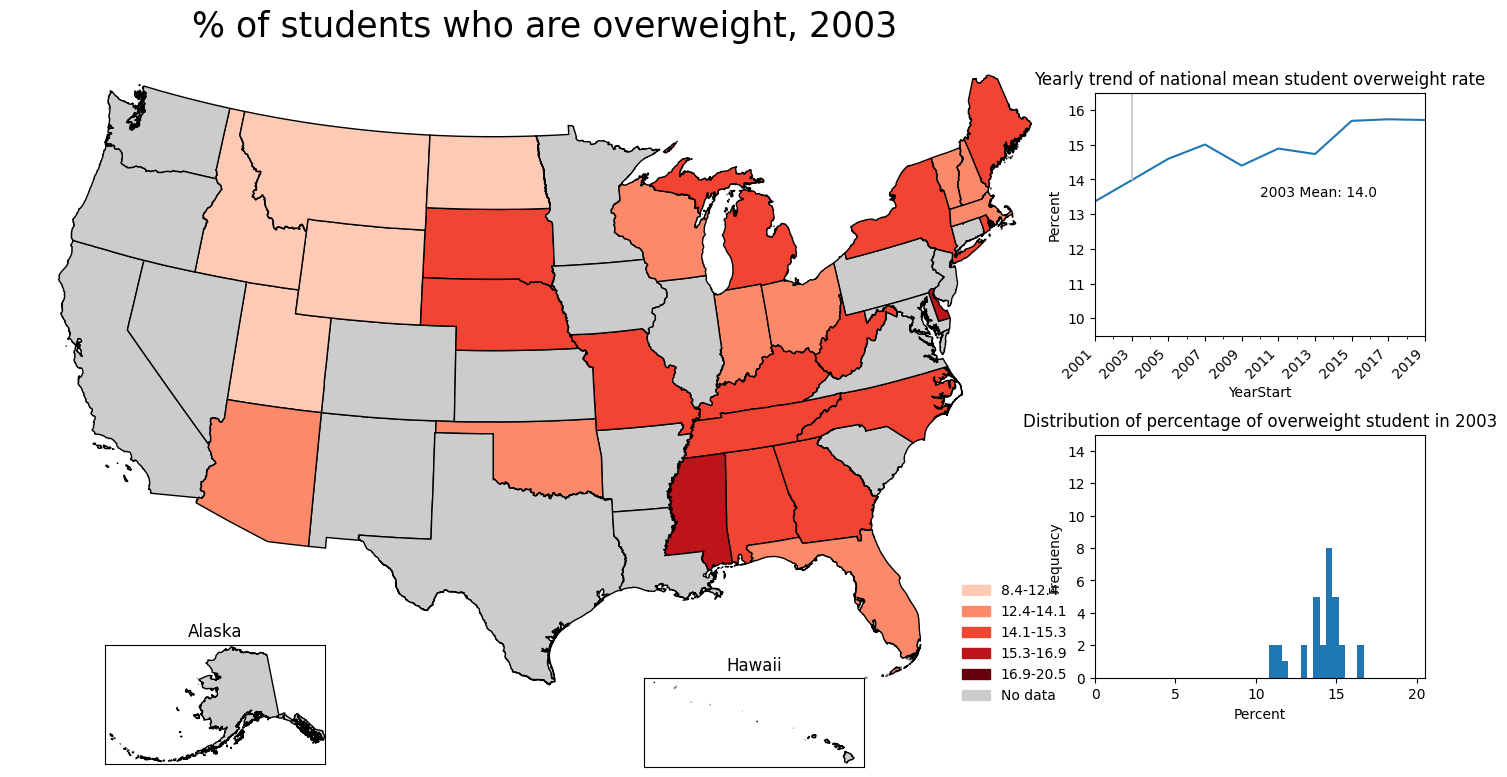

 20%|██        | 2/10 [00:01<00:05,  1.36it/s]


KeyboardInterrupt: 

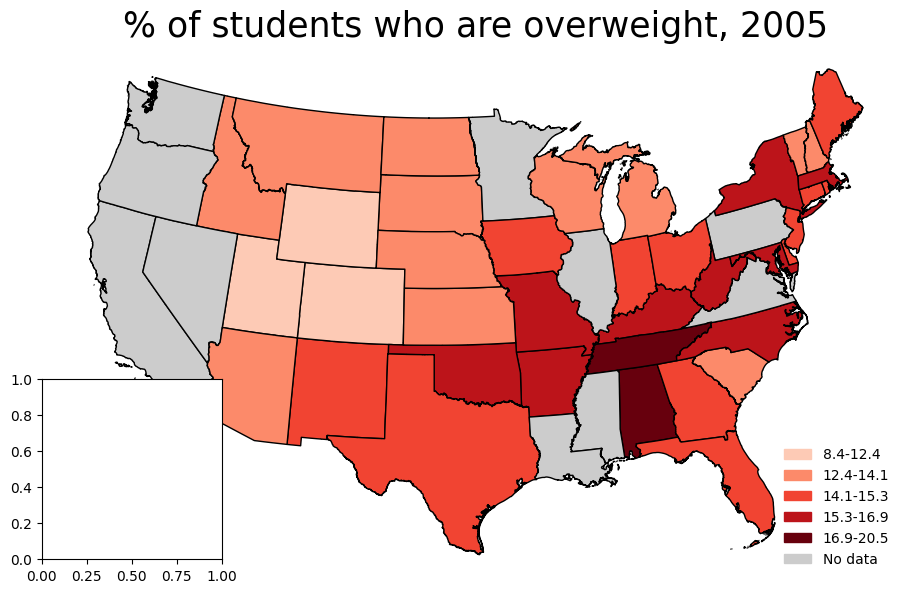

In [104]:
# Overweight
ovw_hist = (
    df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'")
    [['YearStart', 'Data_Value', 'QuestionID', 'LocationAbbr', 'LocationDesc']]
    .query("(QuestionID == 'Q039') & ~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(5)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcde"[jnb.predict(x)])
ovw_gdf = sgdf[['STUSPS', 'geometry']].merge(ovw_hist, how="right", left_on="STUSPS", right_on="LocationAbbr")

# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = ovw_hist["YearStart"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["LocationAbbr", "YearStart"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, on=["LocationAbbr", "YearStart"], how="left")
# augmented_death_df['Data_Value'] = augmented_death_df['Data_Value'].fillna(1e-3)
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (augmented_death_df.groupby(["LocationAbbr", "cls", "YearStart"])["Data_Value"].mean().reset_index()),
    how="left",
    left_on="STUSPS",
    right_on="LocationAbbr",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.Reds
plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

# loop through YearStart numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
for i in tqdm(range(2001, 2021, 2)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = ovw_gdf[~(ovw_gdf["LocationAbbr"].isin(["AK", "HI"])) & (ovw_gdf["YearStart"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [ Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls + ['No data'])
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"% of students who are overweight, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "AK") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "HI") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.58, 0.3, 0.27])
        ax_lg.set_ylim(9.5, 16.5)
        # construct a YearStartly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("YearStart")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the YearStart column in the mean_df dataframe
        mean_df["YearStart"] = pd.to_datetime(mean_df["YearStart"], format="%Y")
        xticks = pd.date_range(
            start=mean_df["YearStart"].min(), end="2020-01-01", freq="2Y"
        )
        # plot the historical trend
        mean_df[["YearStart", "Data_Value"]].plot(
            x="YearStart", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            mean_df.iloc[(i - 2001) // 2]["Data_Value"],
            100,
            "#cccccc",
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean student overweight rate")
        ax_lg.set_ylabel("Percent")
        ax_lg.annotate(
            f"{i} Mean: {str(round(mean_df.loc[(i - 2001) // 2]['Data_Value'], 1))}",
            xy=(pd.to_datetime(2010, format="%Y"), 11),
        )
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of YearStart
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["YearStart"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Distribution of percentage of overweight student in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Percent")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/ovw_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2001_2019_ovw_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/ovw_status/") if os.path.isfile(os.curdir + "./viz_raw/ovw_status/" + f)])):
        image = imageio.imread("../viz_raw/ovw_status/" + filename)
        writer.append_data(image)

mkdir: ../viz_raw/obs_status/: File exists


  0%|          | 0/10 [00:00<?, ?it/s]

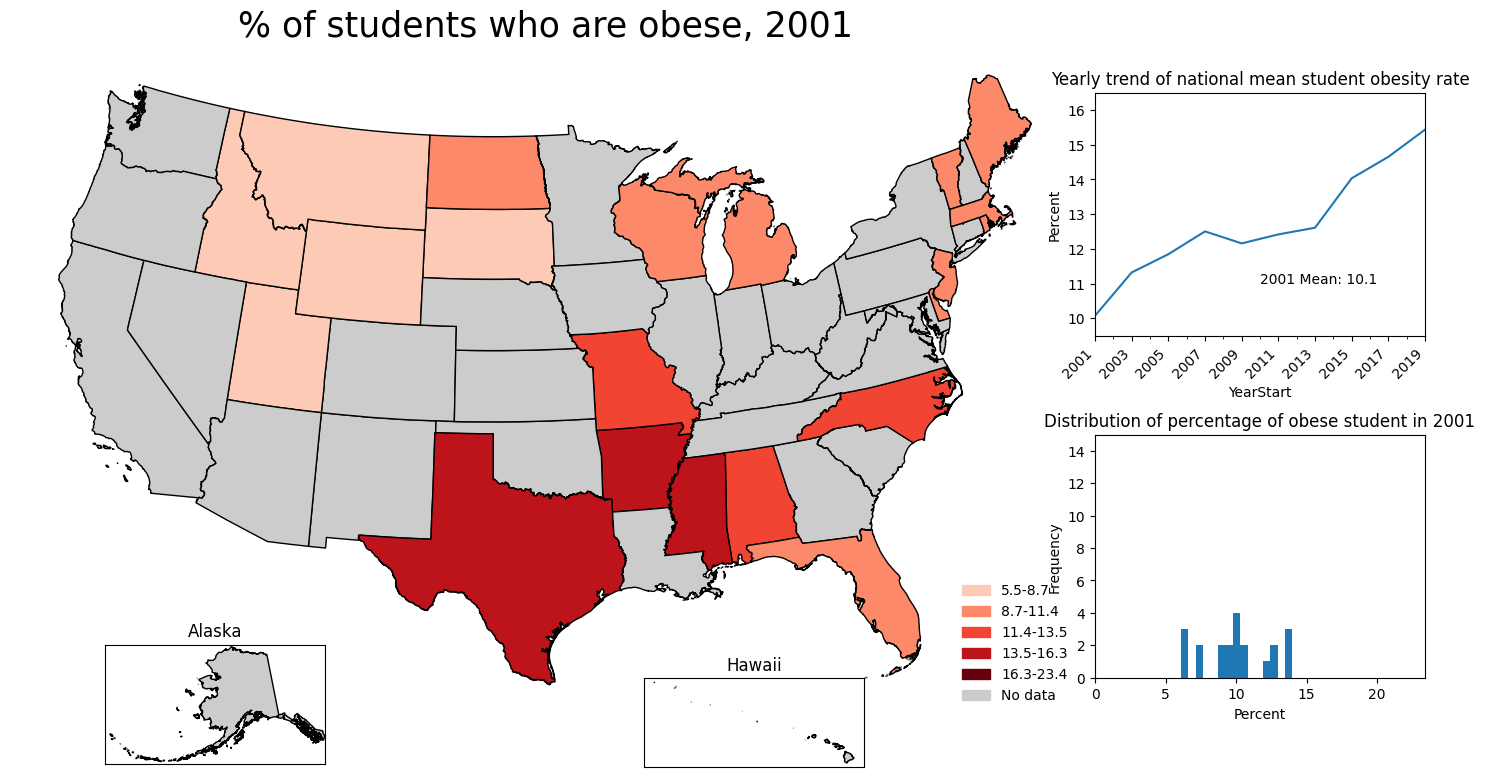

 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

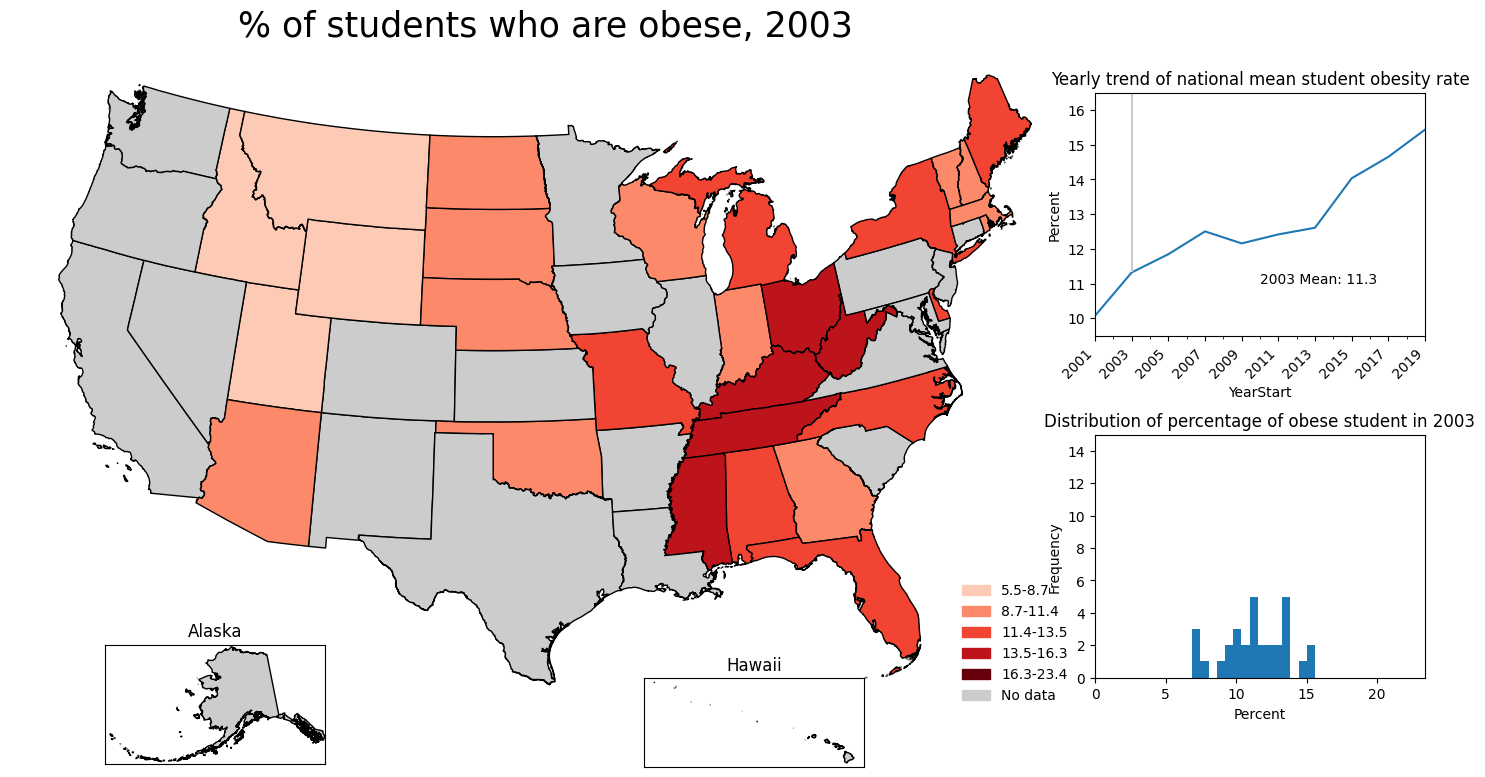

 20%|██        | 2/10 [00:01<00:06,  1.30it/s]

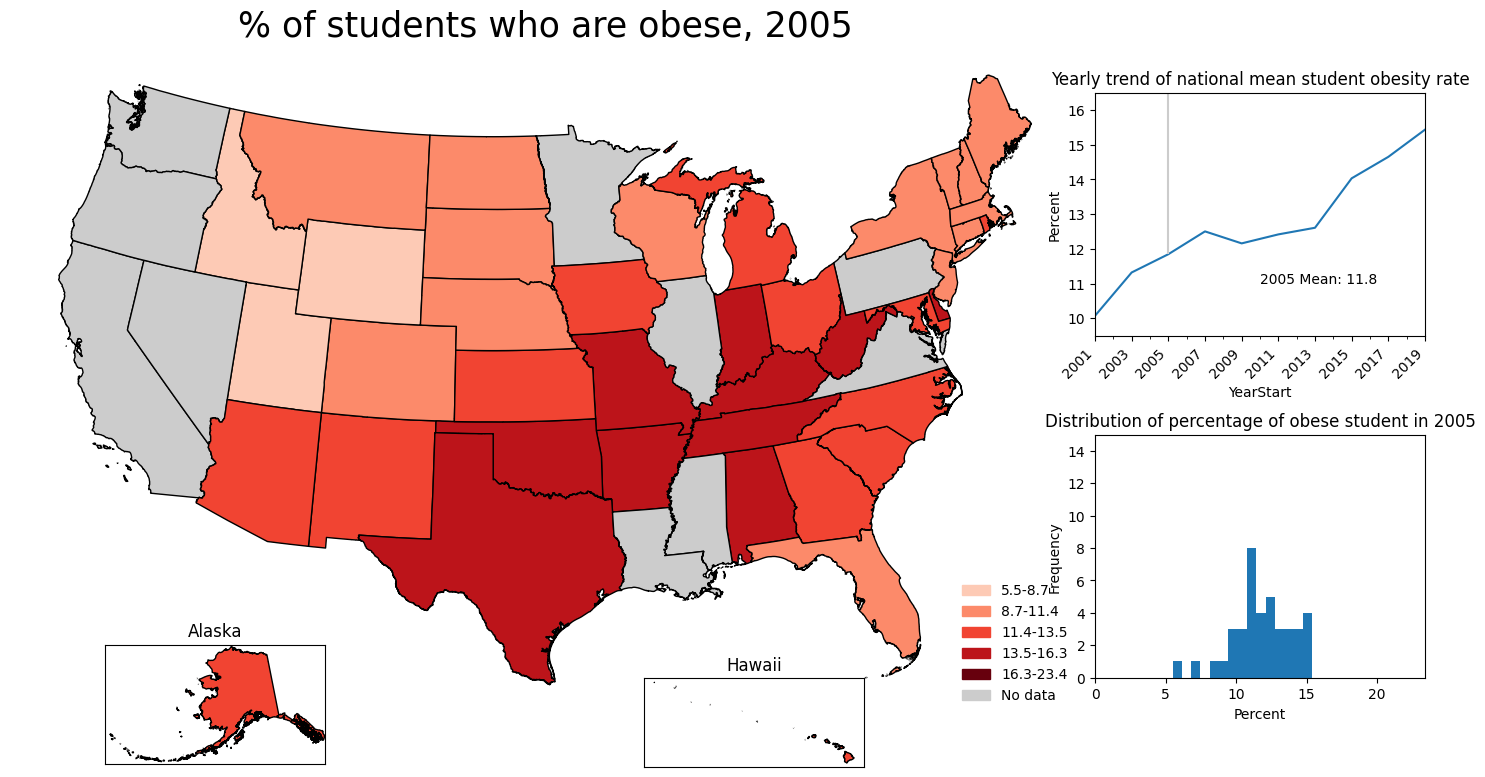

 30%|███       | 3/10 [00:02<00:05,  1.39it/s]

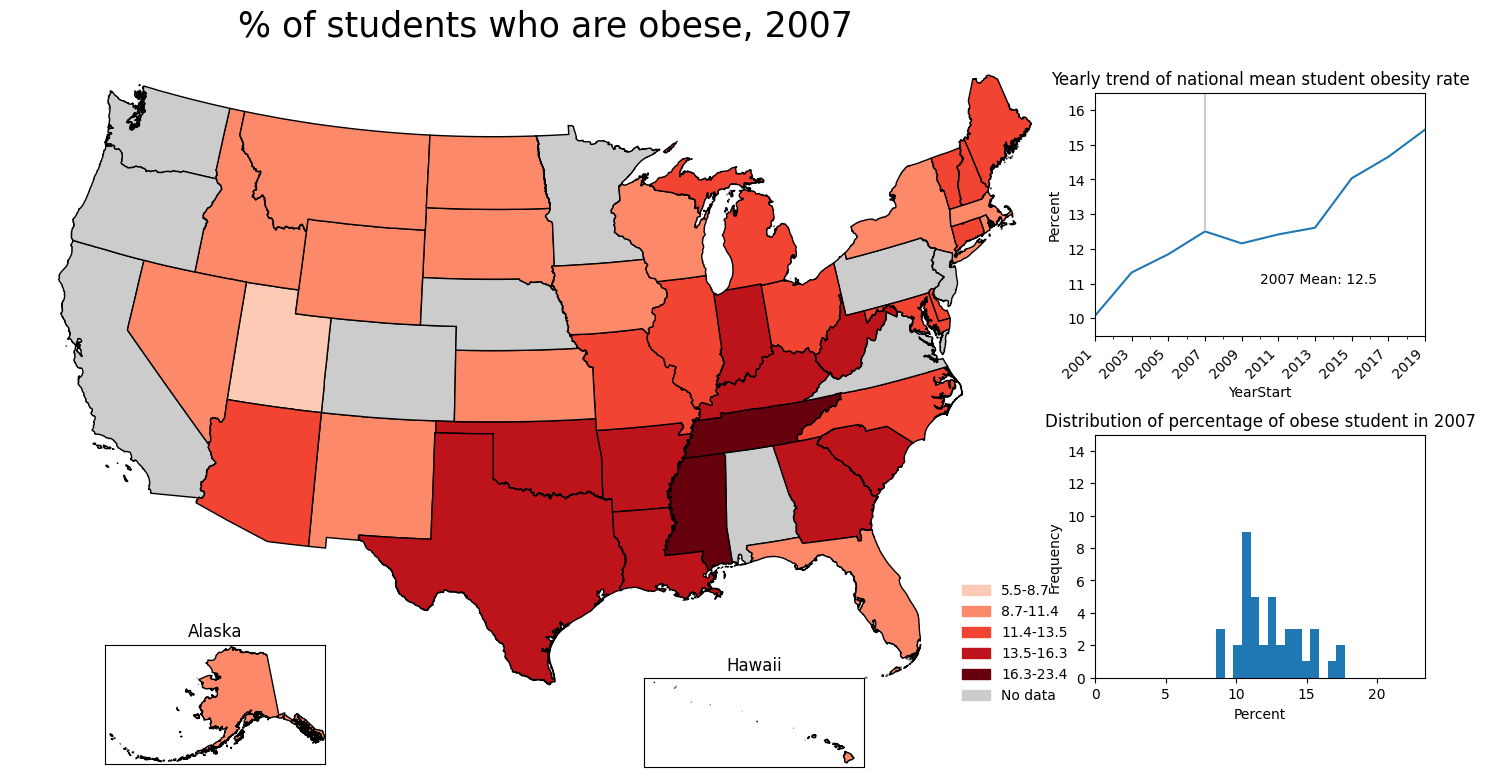

 40%|████      | 4/10 [00:03<00:04,  1.31it/s]


KeyboardInterrupt: 

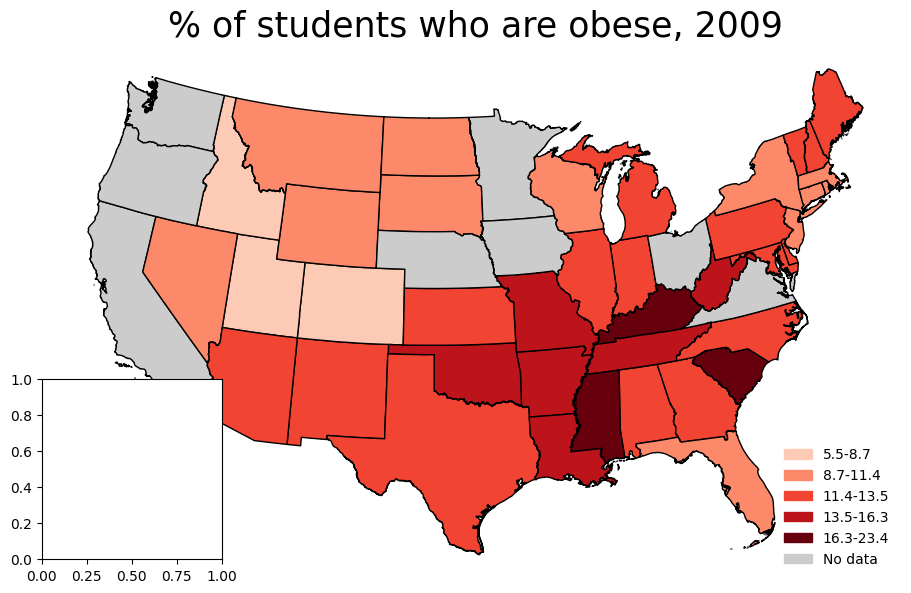

In [106]:
!mkdir ../viz_raw/obs_status/
# Obesity
ovw_hist = (
    df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'")
    [['YearStart', 'Data_Value', 'QuestionID', 'LocationAbbr', 'LocationDesc']]
    .query("(QuestionID == 'Q038') & ~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(5)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcde"[jnb.predict(x)])
ovw_gdf = sgdf[['STUSPS', 'geometry']].merge(ovw_hist, how="right", left_on="STUSPS", right_on="LocationAbbr")

# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = ovw_hist["YearStart"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["LocationAbbr", "YearStart"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, on=["LocationAbbr", "YearStart"], how="left")
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (
        augmented_death_df.groupby(["LocationAbbr", "cls", "YearStart"])["Data_Value"]
        .mean()
        .reset_index()
    ),
    how="left",
    left_on="STUSPS",
    right_on="LocationAbbr",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.Reds
plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

# loop through YearStart numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
for i in tqdm(range(2001, 2021, 2)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = ovw_gdf[~(ovw_gdf["LocationAbbr"].isin(["AK", "HI"])) & (ovw_gdf["YearStart"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls + ['No data'])
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"% of students who are obese, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "AK") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "HI") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.58, 0.3, 0.27])
        ax_lg.set_ylim(9.5, 16.5)
        # construct a YearStartly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("YearStart")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the YearStart column in the mean_df dataframe
        mean_df["YearStart"] = pd.to_datetime(mean_df["YearStart"], format="%Y")
        xticks = pd.date_range(
            start=mean_df["YearStart"].min(), end="2020-01-01", freq="2Y"
        )
        # plot the historical trend
        mean_df[["YearStart", "Data_Value"]].plot(
            x="YearStart", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            mean_df.iloc[(i - 2001) // 2]["Data_Value"],
            100,
            "#cccccc",
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean student obesity rate")
        ax_lg.set_ylabel("Percent")
        ax_lg.annotate(
            f"{i} Mean: {str(round(mean_df.loc[(i - 2001) // 2]['Data_Value'], 1))}",
            xy=(pd.to_datetime(2010, format="%Y"), 11),
        )
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of YearStart
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["YearStart"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Distribution of percentage of obese student in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Percent")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/obs_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2001_2019_obs_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/obs_status/") if os.path.isfile(os.curdir + "./viz_raw/obs_status/" + f)])):
        image = imageio.imread("../viz_raw/obs_status/" + filename)
        writer.append_data(image)

## SNAP Choropleth mapping

In [85]:
set(snap_df.Location.unique()).difference(sgdf['NAME'].unique())
set(sgdf['NAME'].unique()).difference(snap_df.Location.unique())

{'American Samoa',
 'Commonwealth of the Northern Mariana Islands',
 'Puerto Rico',
 'United States Virgin Islands'}

In [86]:
!mkdir ../viz_raw/snap_status/
# OWS 
ovw_hist = (
    snap_df.query("Location != 'United States'")
    [['Location', 'year', 'Average Monthly SNAP Benefits per Participant']]
    .rename(columns={"Average Monthly SNAP Benefits per Participant": "Data_Value"})
    .query("~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(7)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"\${a}-\${b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcdefg"[jnb.predict(x)])
ovw_gdf = sgdf[['NAME',  'geometry']].merge(ovw_hist, how="right", left_on="NAME", right_on="Location")

mkdir: ../viz_raw/snap_status/: File exists


In [87]:
# 1. Create a complete list of state-year combinations
all_states = sgdf["NAME"].unique()
all_years = ovw_hist["year"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["NAME", "year"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, left_on=["NAME", "year"], right_on=['Location', 'year'], how="left")
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (augmented_death_df.groupby(["Location", "cls", "year"])["Data_Value"].mean().reset_index()),
    how="inner",
    left_on=['NAME'],
    right_on="Location",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["Location"].isin(['American Samoa', 
                                  'Guam', 
                                  'Commonwealth of the Northern Mariana Islands',
                                  'Puerto Rico',
                                  'United States Virgin Islands',])
    ].index
)

In [88]:

# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.Reds
plot_color = [mcolors.to_hex(c) for c in colmap(np.linspace(0, 1, 8)[1:])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'x'], plot_color)}

# loop through year numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
# 2023
for i in tqdm(range(2002, 2023)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 10))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = (
        ovw_gdf[~(ovw_gdf["Location"].isin(["Alaska", "Hawaii"])) & 
                (ovw_gdf["year"] == i)].to_crs(epsg=2163)
                )
    
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e', 'f', 'g']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, 
              frameon=False, 
            #   loc='lower right', 
              labels=cls + ['No data'],
              loc=(0.85, -0.08)
              )
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Average monthly SNAP benefit per Participant, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.14, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["Location"] == "Alaska") & (ovw_gdf["year"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.56, 0.12, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["Location"] == "Hawaii") & (ovw_gdf["year"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.54, 0.3, 0.27])
        ax_lg.set_ylim(70, 240)
        # construct a yearly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("year")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the year column in the mean_df dataframe
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        # plot the historical trend
        mean_df[["year", "Data_Value"]].plot(
            x="year", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            mean_df.iloc[(i - 2002)]["Data_Value"],
            250,
            "#cccccc",
        )

        xticks = pd.date_range(
            start=mean_df["year"].min(), end="2023-01-01", freq="2Y"
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean monthly SNAP benefits")
        ax_lg.set_ylabel("Dollars")
        ax_lg.annotate(
            f"${i} Mean: {str(round(mean_df.loc[(i - 2002)]['Data_Value'], 1))} USD",
            xy=(pd.to_datetime(2004, format="%Y"), 150),
        )
        ax_lg.set_xlabel("Fiscal Year")
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.17, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["year"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=10
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Average monthly SNAP benefit per perticipant in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 25)
        ax_hist.set_xlabel("Dollars")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/snap_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2002_2022_snap_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/snap_status/") if os.path.isfile(os.curdir + "./viz_raw/snap_status/" + f)])):
        image = imageio.imread("../viz_raw/snap_status/" + filename)
        writer.append_data(image)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:56<00:00,  2.68s/it]


generating animation...


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


In [89]:
# Requires imagemagick to run - convert gif to loop infinitely
!convert -loop 0 ../viz/2001_2019_obs_status.gif ../viz/_present_2001_2019_obs_status.gif
!convert -loop 0 ../viz/2001_2019_ovw_status.gif ../viz/_present_2001_2019_ovw_status.gif
!convert -loop 0 ../viz/2002_2022_snap_status.gif ../viz/_present_2002_2022_snap_status.gif